## Setup and Imports

In [40]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Add parent directory to path
sys.path.append(str(Path.cwd().parent))

from core.multi_asset_loader import load_assets
from core.multi_asset_signal import SingleAssetWrapper
from core.portfolio_manager import (
    PortfolioManager, 
    PortfolioConfig, 
    run_multi_asset_backtest
)
from signals.momentum import MomentumSignalV2
from signals.mean_reversion import MeanReversionSignal  
# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Load Multi-Asset Data

Load ES (S&P 500) and GC (Gold) futures data from 2015-2024.

In [25]:
# Load data
tickers = ['ES', 'GC', 'NQ']
start_date = '2000-01-01'
end_date = '2024-12-31'

print(f"Loading {len(tickers)} assets: {tickers}")
prices = load_assets(tickers, start_date=start_date, end_date=end_date)

print(f"\nDate range: {prices['ES'].index[0]} to {prices['ES'].index[-1]}")
print(f"Total trading days: {len(prices['ES'])}")

# Display first few rows
print("\nES Data (first 5 rows):")
print(prices['ES'].head())
print("\nGC Data (first 5 rows):")
print(prices['GC'].head())

Loading 3 assets: ['ES', 'GC', 'NQ']

Loading 3 assets: ['ES', 'GC', 'NQ']
✓ ES: 6134 rows, 2000-09-18 to 2024-12-31
✓ GC: 6106 rows, 2000-08-30 to 2024-12-31
✓ NQ: 6134 rows, 2000-09-18 to 2024-12-31

Common date range: 2000-09-18 to 2024-12-31
Filtered date range: 2000-09-18 to 2024-12-31

Total unique dates: 6136
  ES: 2 missing dates, filled 2, 0 remain
  GC: 42 missing dates, filled 42, 0 remain
  NQ: 2 missing dates, filled 2, 0 remain

ALIGNMENT SUMMARY
ES: 6136/6136 valid dates (100.0%)
GC: 6136/6136 valid dates (100.0%)
NQ: 6136/6136 valid dates (100.0%)

Date range: 2000-09-18 00:00:00 to 2024-12-31 00:00:00
Total trading days: 6136

ES Data (first 5 rows):
               Open     High      Low   Close    Volume Ticker
Date                                                          
2000-09-18  1485.25  1489.75  1462.25  1467.5  104794.0     ES
2000-09-19  1467.00  1482.75  1466.75  1478.5  103371.0     ES
2000-09-20  1478.75  1480.50  1450.25  1469.5  109667.0     ES
2000-09-2

## 2. Calculate Asset Correlations

Analyze return correlations between assets to understand diversification potential.

Return Correlation Matrix:
          ES        GC        NQ
ES  1.000000 -0.008023  0.867844
GC -0.008023  1.000000 -0.022473
NQ  0.867844 -0.022473  1.000000

ES-GC Correlation: -0.008


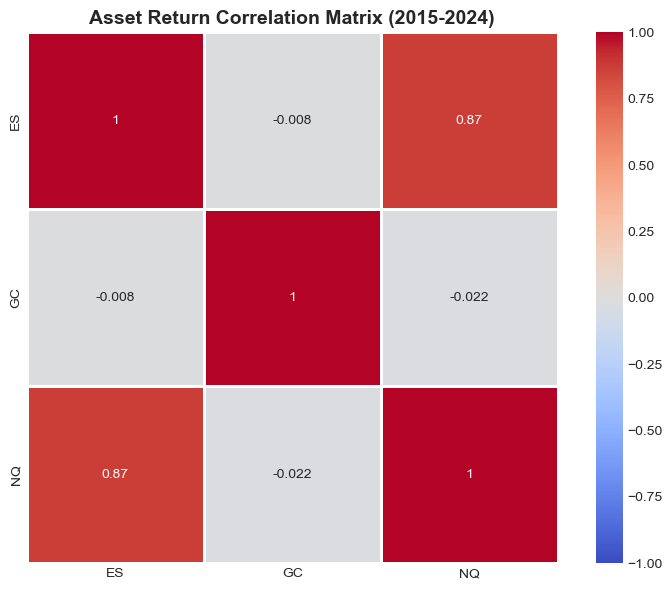

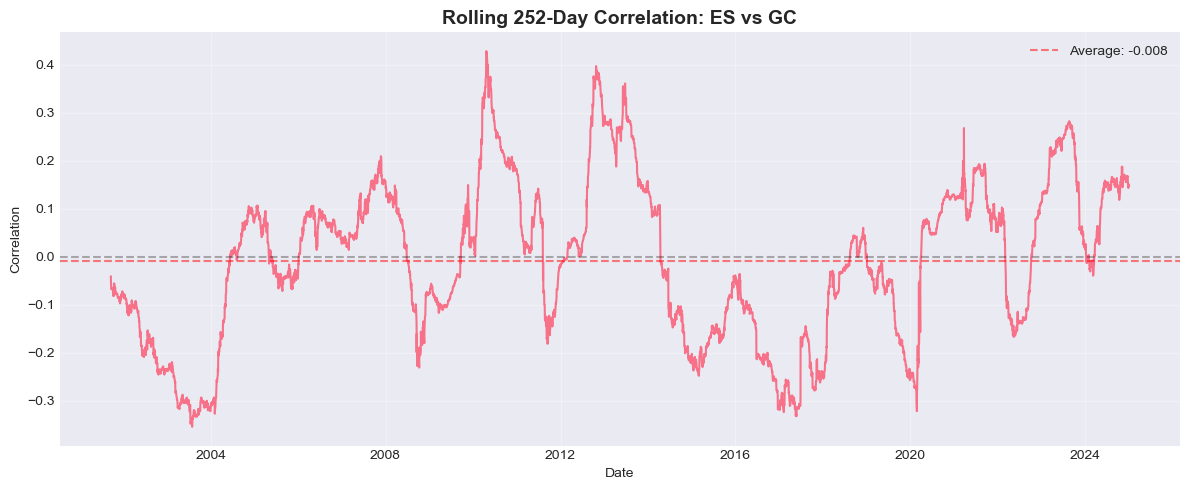

In [26]:
# Calculate daily returns
returns = pd.DataFrame({
    ticker: prices[ticker]['Close'].pct_change()
    for ticker in tickers
}).dropna()

# Correlation matrix
corr_matrix = returns.corr()
print("Return Correlation Matrix:")
print(corr_matrix)
print(f"\nES-GC Correlation: {corr_matrix.loc['ES', 'GC']:.3f}")

# Visualize correlation
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True, linewidths=1)
plt.title('Asset Return Correlation Matrix (2015-2024)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Calculate rolling correlation
rolling_corr = returns['ES'].rolling(252).corr(returns['GC'])


plt.figure(figsize=(12, 5))
plt.plot(rolling_corr.index, rolling_corr.values, linewidth=1.5)
plt.axhline(y=0, color='black', linestyle='--', alpha=0.3)
plt.axhline(y=corr_matrix.loc['ES', 'GC'], color='red', linestyle='--', 
            alpha=0.5, label=f'Average: {corr_matrix.loc["ES", "GC"]:.3f}')
plt.title('Rolling 252-Day Correlation: ES vs GC', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Generate Signals

Use momentum strategy (120-day lookback, 2% entry, -1% exit, 100-day SMA filter).

In [27]:
# Create momentum signal
momentum = MomentumSignalV2(
    lookback=120,
    entry_threshold=0.02,
    exit_threshold=-0.01,
    sma_filter=100
)

# Wrap for multi-asset use
multi_signal = SingleAssetWrapper(momentum)

# Generate signals
print("Generating signals...")
signals = multi_signal.generate(prices)

# Analyze signal activity
for ticker in tickers:
    sig = signals[ticker]['Signal']
    n_long = (sig == 1).sum()
    n_short = (sig == -1).sum()
    n_flat = (sig == 0).sum()
    pct_long = n_long / len(sig) * 100
    
    print(f"\n{ticker} Signal Activity:")
    print(f"  Long: {n_long} days ({pct_long:.1f}%)")
    print(f"  Short: {n_short} days")
    print(f"  Flat: {n_flat} days")

# Display signal transitions
print("\nES Signal (sample):")
print(signals['ES'][['Close', 'Signal']].head(130))

Generating signals...

ES Signal Activity:
  Long: 5772 days (94.1%)
  Short: 0 days
  Flat: 364 days

GC Signal Activity:
  Long: 5970 days (97.3%)
  Short: 0 days
  Flat: 166 days

NQ Signal Activity:
  Long: 5767 days (94.0%)
  Short: 0 days
  Flat: 369 days

ES Signal (sample):
              Close  Signal
Date                       
2000-09-18  1467.50     0.0
2000-09-19  1478.50     0.0
2000-09-20  1469.50     0.0
2000-09-21  1469.50     0.0
2000-09-22  1468.50     0.0
...             ...     ...
2001-03-19  1180.50     0.0
2001-03-20  1152.50     0.0
2001-03-21  1132.75     0.0
2001-03-22  1119.00     0.0
2001-03-23  1153.25     0.0

[130 rows x 2 columns]

ES Signal Activity:
  Long: 5772 days (94.1%)
  Short: 0 days
  Flat: 364 days

GC Signal Activity:
  Long: 5970 days (97.3%)
  Short: 0 days
  Flat: 166 days

NQ Signal Activity:
  Long: 5767 days (94.0%)
  Short: 0 days
  Flat: 369 days

ES Signal (sample):
              Close  Signal
Date                       
2000-09-18  

## 4. Run Multi-Asset Backtest

Portfolio configuration:
- Initial capital: $100,000
- Rebalance threshold: 10% drift
- Transaction cost: 3 bps (0.03%)
- Allocation: Equal weight among active signals

In [28]:
# Configure portfolio
config = PortfolioConfig(
    initial_capital=100000,
    rebalance_threshold=0.10,  # 10% drift triggers rebalance
    transaction_cost_bps=3.0   # 0.03% per trade
)

# Run backtest
print("Running backtest...")
pm, equity_curve, trades = run_multi_asset_backtest(signals, prices, config)

# Calculate metrics
metrics = pm.calculate_metrics()

print("\n" + "="*60)
print("MULTI-ASSET PORTFOLIO RESULTS")
print("="*60)
print(f"Initial Capital:      ${config.initial_capital:,.0f}")
print(f"Final Portfolio Value: ${pm.portfolio_value:,.2f}")
print(f"Total Return:         {metrics['Total Return']*100:.2f}%")
print(f"CAGR:                 {metrics['CAGR']*100:.2f}%")
print(f"Sharpe Ratio:         {metrics['Sharpe Ratio']:.3f}")
print(f"Max Drawdown:         {metrics['Max Drawdown']*100:.2f}%")
print(f"Annual Volatility:    {metrics['Annual Volatility']*100:.2f}%")
print(f"Total Trades:         {metrics['Total Trades']}")
print(f"Transaction Costs:    ${metrics['Transaction Costs']:.2f}")
print("="*60)

Running backtest...

MULTI-ASSET PORTFOLIO RESULTS
Initial Capital:      $100,000
Final Portfolio Value: $1,098,213.26
Total Return:         998.21%
CAGR:                 10.34%
Sharpe Ratio:         0.745
Max Drawdown:         -38.67%
Annual Volatility:    14.67%
Total Trades:         25
Transaction Costs:    $196.17

MULTI-ASSET PORTFOLIO RESULTS
Initial Capital:      $100,000
Final Portfolio Value: $1,098,213.26
Total Return:         998.21%
CAGR:                 10.34%
Sharpe Ratio:         0.745
Max Drawdown:         -38.67%
Annual Volatility:    14.67%
Total Trades:         25
Transaction Costs:    $196.17


## 5. Analyze Trade History

In [29]:
# Analyze trades
if not trades.empty:
    # Format for display
    trade_display = trades.copy()
    trade_display['Date'] = trade_display['Date'].dt.strftime('%Y-%m-%d')
    trade_display['Price'] = trade_display['Price'].apply(lambda x: f"${x:.2f}")
    trade_display['Value'] = trade_display['Value'].apply(lambda x: f"${x:.2f}")
    trade_display['TransactionCost'] = trade_display['TransactionCost'].apply(lambda x: f"${x:.2f}")
    
    print("\nAll Trades:")
    print(trade_display.to_string(index=False))
    
    # Trade type breakdown
    print("\nTrade Type Breakdown:")
    print(trades['Type'].value_counts())
    
    print("\nTrades by Ticker:")
    print(trades['Ticker'].value_counts())
else:
    print("No trades executed.")


All Trades:
      Date Ticker      Type      Shares     Price      Value TransactionCost  Signal  PrevSignal                Note  CurrentValue   TargetValue
2001-05-16     GC     Entry  363.970588   $272.00  $99000.00          $29.70     1.0         0.0 Used available cash           NaN           NaN
2002-03-01     ES     Entry    0.848022  $1132.75    $960.60           $0.29     1.0         0.0 Used available cash           NaN           NaN
2002-03-01     ES Rebalance   47.452058  $1132.75  $53751.32          $16.13     1.0         NaN                 NaN    960.597000  54711.916147
2002-03-01     GC Rebalance -180.373554   $298.00 $-53751.32          $16.13     1.0         NaN                 NaN 108463.235294  54711.916147
2002-03-08     ES Rebalance  -16.947619  $1164.00 $-19727.03           $5.92     1.0         NaN                 NaN  56221.293662  36494.264787
2002-03-08     GC Rebalance  -57.798123   $290.10 $-16767.24           $5.03     1.0         NaN                 NaN 

## 6. Visualize Portfolio Equity Curve

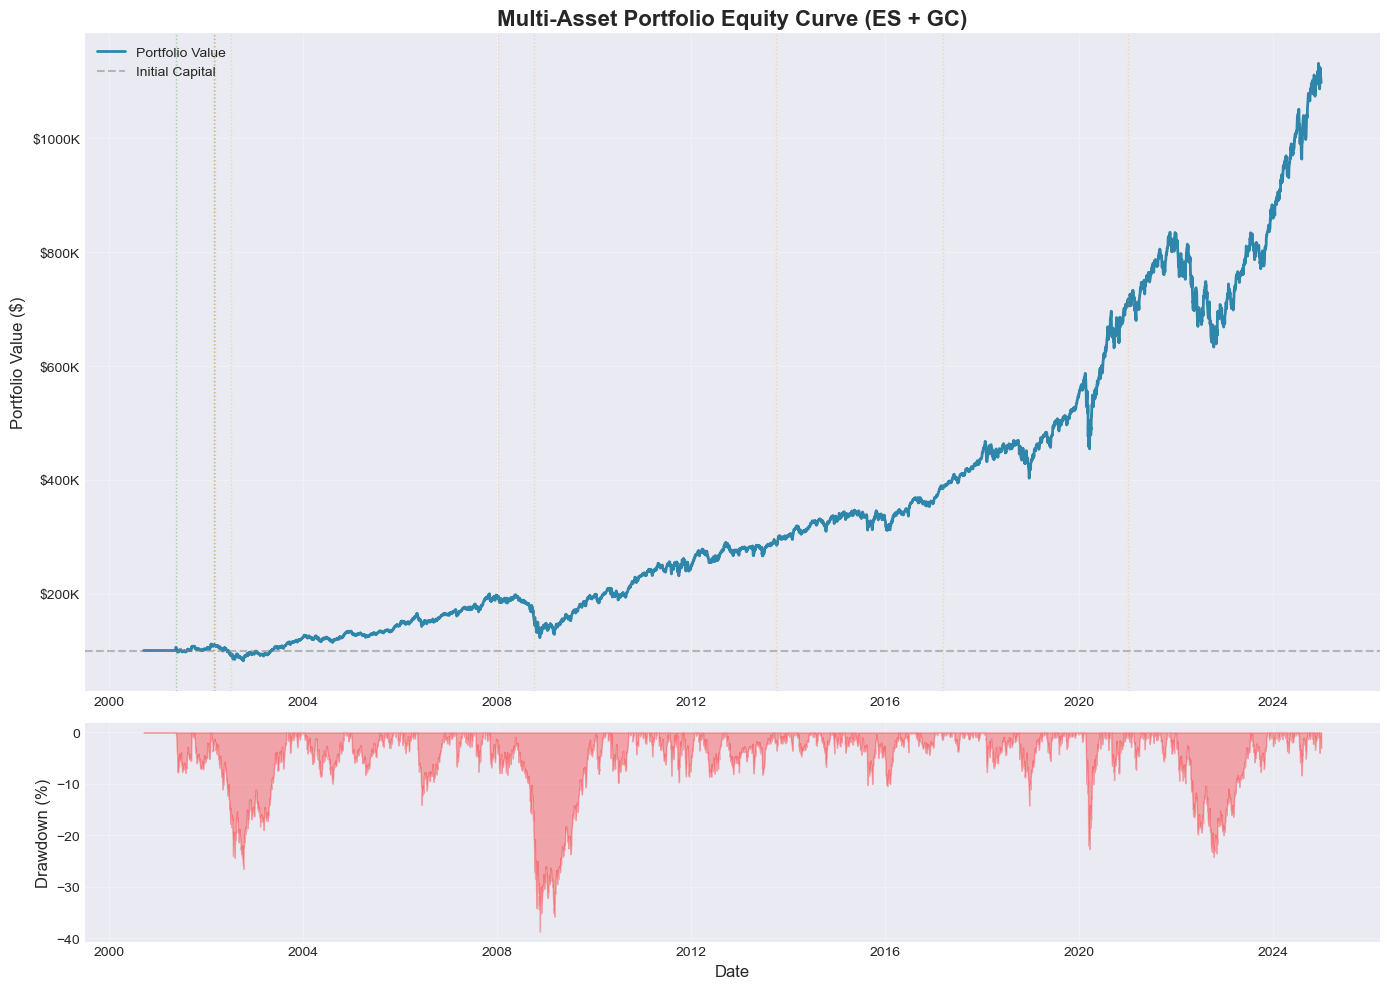


Max Drawdown: -38.67% on 2008-11-20


In [30]:
# Extract equity curve
# equity_curve is already a DataFrame, we need to flatten the nested Positions column
equity_data = []
for idx, row in equity_curve.iterrows():
    flat_row = {
        'date': row['Date'],
        'portfolio_value': row['TotalValue'],
        'cash': row['Cash']
    }
    # Extract position values from nested dict
    if isinstance(row['Positions'], dict):
        for ticker, pos_data in row['Positions'].items():
            flat_row[ticker] = pos_data['Value']
    equity_data.append(flat_row)

equity_df = pd.DataFrame(equity_data)
equity_df['date'] = pd.to_datetime(equity_df['date'])
equity_df.set_index('date', inplace=True)

# Plot equity curve
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), 
                                gridspec_kw={'height_ratios': [3, 1]})

# Portfolio value
ax1.plot(equity_df.index, equity_df['portfolio_value'], 
         linewidth=2, label='Portfolio Value', color='#2E86AB')
ax1.axhline(y=config.initial_capital, color='gray', 
            linestyle='--', alpha=0.5, label='Initial Capital')
ax1.set_title('Multi-Asset Portfolio Equity Curve (ES + GC)', 
              fontsize=16, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Mark trade dates
if not trades.empty:
    entry_trades = trades[trades['Type'].isin(['Entry', 'Flip'])]
    rebalance_trades = trades[trades['Type'] == 'Rebalance']
    
    for date in entry_trades['Date'].unique():
        ax1.axvline(x=date, color='green', alpha=0.3, linestyle=':', linewidth=1)
    for date in rebalance_trades['Date'].unique():
        ax1.axvline(x=date, color='orange', alpha=0.3, linestyle=':', linewidth=1)

# Drawdown
running_max = equity_df['portfolio_value'].cummax()
drawdown = (equity_df['portfolio_value'] - running_max) / running_max * 100
ax2.fill_between(equity_df.index, drawdown, 0, color='red', alpha=0.3)
ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMax Drawdown: {drawdown.min():.2f}% on {drawdown.idxmin().date()}")

## 7. Compare to Single-Asset Performance

Run individual backtests for ES and GC to compare against the portfolio.

In [32]:
# Run ES-only backtest
es_signals = {'ES': signals['ES']}
es_prices = {'ES': prices['ES']}
pm_es, equity_es, trades_es = run_multi_asset_backtest(es_signals, es_prices, config)
metrics_es = pm_es.calculate_metrics()

# Run GC-only backtest
gc_signals = {'GC': signals['GC']}
gc_prices = {'GC': prices['GC']}
pm_gc, equity_gc, trades_gc = run_multi_asset_backtest(gc_signals, gc_prices, config)
metrics_gc = pm_gc.calculate_metrics()

# Run NQ-only backtest
nq_signals = {'NQ': signals['NQ']}
nq_prices = {'NQ': prices['NQ']}
pm_nq, equity_nq, trades_nq = run_multi_asset_backtest(nq_signals, nq_prices, config)
metrics_nq = pm_nq.calculate_metrics()

# Comparison table
comparison = pd.DataFrame({
    'ES Only': [
        f"{metrics_es['Total Return']*100:.2f}%",
        f"{metrics_es['CAGR']*100:.2f}%",
        f"{metrics_es['Sharpe Ratio']:.3f}",
        f"{metrics_es['Max Drawdown']*100:.2f}%",
        f"{metrics_es['Annual Volatility']*100:.2f}%",
        metrics_es['Total Trades']
    ],
    'GC Only': [
        f"{metrics_gc['Total Return']*100:.2f}%",
        f"{metrics_gc['CAGR']*100:.2f}%",
        f"{metrics_gc['Sharpe Ratio']:.3f}",
        f"{metrics_gc['Max Drawdown']*100:.2f}%",
        f"{metrics_gc['Annual Volatility']*100:.2f}%",
        metrics_gc['Total Trades']
    ],
    'NQ Only': [
        f"{metrics_nq['Total Return']*100:.2f}%",
        f"{metrics_nq['CAGR']*100:.2f}%",
        f"{metrics_nq['Sharpe Ratio']:.3f}",
        f"{metrics_nq['Max Drawdown']*100:.2f}%",
        f"{metrics_nq['Annual Volatility']*100:.2f}%",
        metrics_nq['Total Trades']
    ],
    'ES + GC + NQ Portfolio': [
        f"{metrics['Total Return']*100:.2f}%",
        f"{metrics['CAGR']*100:.2f}%",
        f"{metrics['Sharpe Ratio']:.3f}",
        f"{metrics['Max Drawdown']*100:.2f}%",
        f"{metrics['Annual Volatility']*100:.2f}%",
        metrics['Total Trades']
    ]
}, index=['Total Return', 'CAGR', 'Sharpe Ratio', 'Max Drawdown', 'Volatility', 'Trades'])

print("\n" + "="*70)
print("PERFORMANCE COMPARISON")
print("="*70)
print(comparison)
print("="*70)

# Calculate diversification benefit
max_single_sharpe = max(metrics_es['Sharpe Ratio'], metrics_gc['Sharpe Ratio'])
diversification_ratio = metrics['Sharpe Ratio'] / max_single_sharpe
print(f"\nDiversification Benefit: {(diversification_ratio - 1) * 100:.1f}% Sharpe improvement")


PERFORMANCE COMPARISON
              ES Only  GC Only   NQ Only ES + GC + NQ Portfolio
Total Return  419.74%  857.92%  1251.50%                998.21%
CAGR            7.00%    9.72%    11.29%                 10.34%
Sharpe Ratio    0.459    0.630     0.597                  0.745
Max Drawdown  -56.71%  -44.30%   -53.49%                -38.67%
Volatility     18.49%   17.04%    21.93%                 14.67%
Trades              1        1         1                     25

Diversification Benefit: 18.2% Sharpe improvement


## 8. Plot Comparative Equity Curves

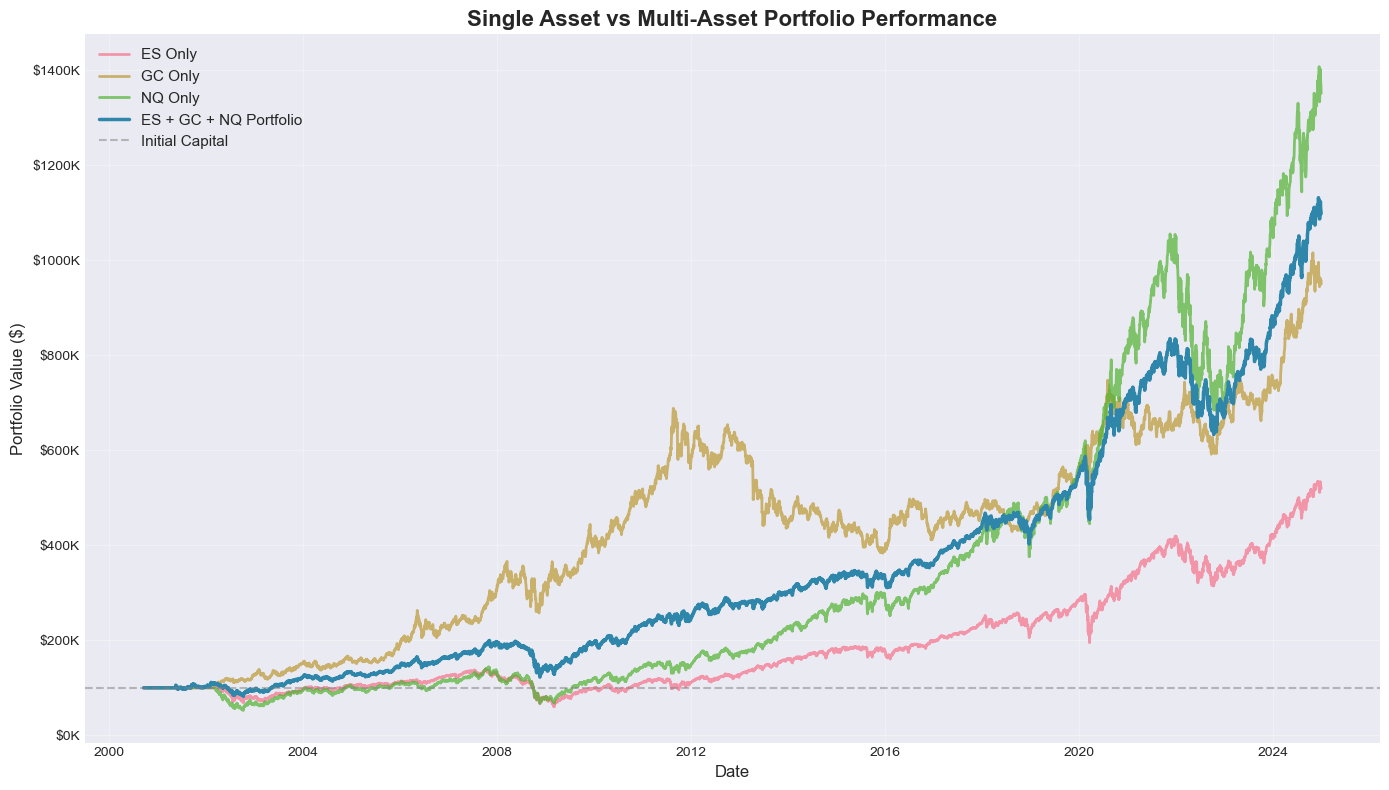

In [33]:
# Flatten equity curves for single assets
def flatten_equity_curve_df(equity_df):
    """Flatten nested equity curve DataFrame structure."""
    data = []
    for idx, row in equity_df.iterrows():
        flat_row = {
            'date': row['Date'],
            'portfolio_value': row['TotalValue'],
            'cash': row['Cash']
        }
        if isinstance(row['Positions'], dict):
            for ticker, pos_data in row['Positions'].items():
                flat_row[ticker] = pos_data['Value']
        data.append(flat_row)
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    return df

equity_es_df = flatten_equity_curve_df(equity_es)
equity_gc_df = flatten_equity_curve_df(equity_gc)
equity_nq_df = flatten_equity_curve_df(equity_nq)

# Plot all three
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(equity_es_df.index, equity_es_df['portfolio_value'], 
         label='ES Only', linewidth=2, alpha=0.7)
ax.plot(equity_gc_df.index, equity_gc_df['portfolio_value'], 
         label='GC Only', linewidth=2, alpha=0.7)
ax.plot(equity_nq_df.index, equity_nq_df['portfolio_value'], 
         label='NQ Only', linewidth=2, alpha=0.7)
ax.plot(equity_df.index, equity_df['portfolio_value'], 
         label='ES + GC + NQ Portfolio', linewidth=2.5, color='#2E86AB')
ax.axhline(y=config.initial_capital, color='gray', 
            linestyle='--', alpha=0.5, label='Initial Capital')

ax.set_title('Single Asset vs Multi-Asset Portfolio Performance', 
          fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Portfolio Value ($)', fontsize=12)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
plt.tight_layout()
plt.show()

## 9. Monthly Returns Heatmap

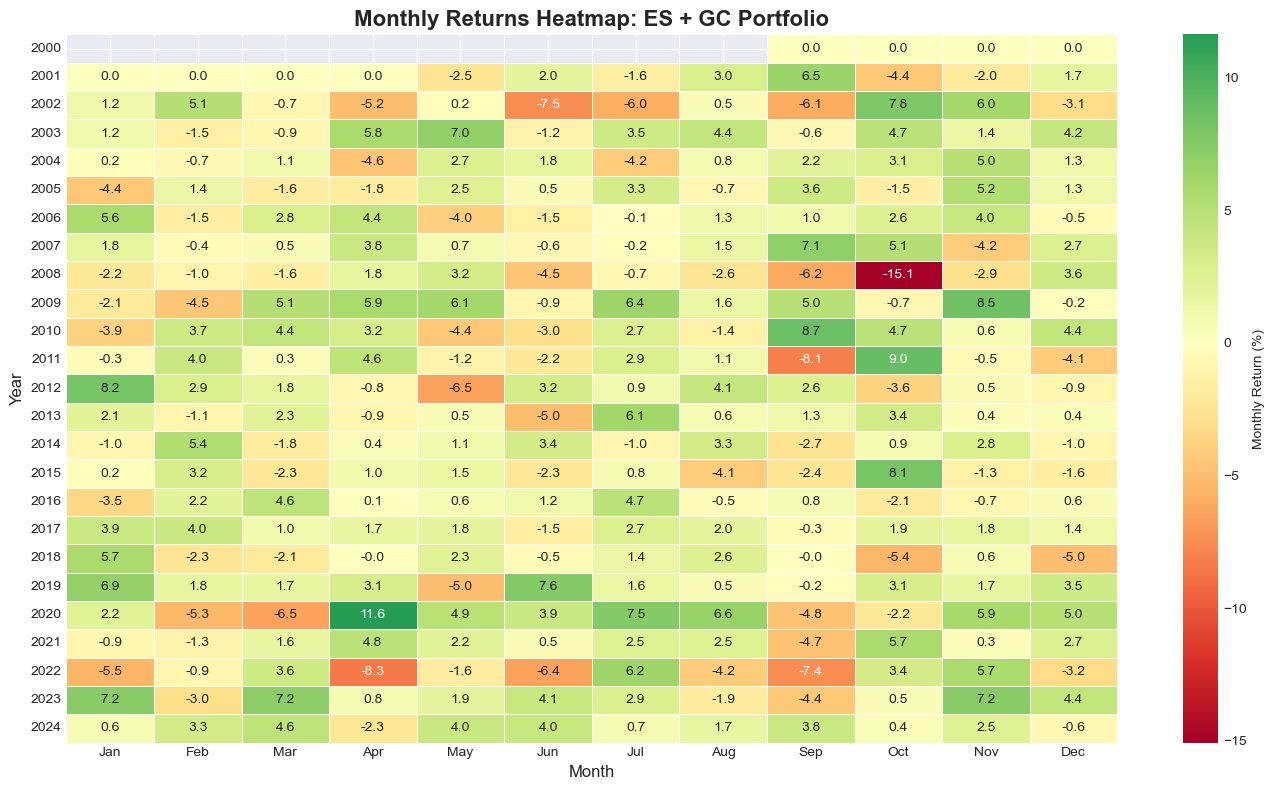


Monthly Return Statistics:
  Mean: 0.89%
  Std Dev: 3.62%
  Best Month: 11.62% (2020-04)
  Worst Month: -15.06% (2008-10)
  Win Rate: 60.3%


In [34]:
# Calculate monthly returns
equity_df['returns'] = equity_df['portfolio_value'].pct_change()
monthly_returns = equity_df['returns'].resample('ME').apply(lambda x: (1 + x).prod() - 1) * 100

# Create pivot table for heatmap
monthly_returns_df = pd.DataFrame({
    'Year': monthly_returns.index.year,
    'Month': monthly_returns.index.month,
    'Return': monthly_returns.values
})
heatmap_data = monthly_returns_df.pivot(index='Year', columns='Month', values='Return')

# Month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
heatmap_data.columns = [month_names[i-1] for i in heatmap_data.columns]

# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdYlGn', center=0,
            cbar_kws={'label': 'Monthly Return (%)'}, linewidths=0.5)
plt.title('Monthly Returns Heatmap: ES + GC Portfolio', fontsize=16, fontweight='bold')
plt.ylabel('Year', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.tight_layout()
plt.show()

# Summary stats
print(f"\nMonthly Return Statistics:")
print(f"  Mean: {monthly_returns.mean():.2f}%")
print(f"  Std Dev: {monthly_returns.std():.2f}%")
print(f"  Best Month: {monthly_returns.max():.2f}% ({monthly_returns.idxmax().strftime('%Y-%m')})")
print(f"  Worst Month: {monthly_returns.min():.2f}% ({monthly_returns.idxmin().strftime('%Y-%m')})")
print(f"  Win Rate: {(monthly_returns > 0).sum() / len(monthly_returns) * 100:.1f}%")

## 10. Position Allocation Over Time

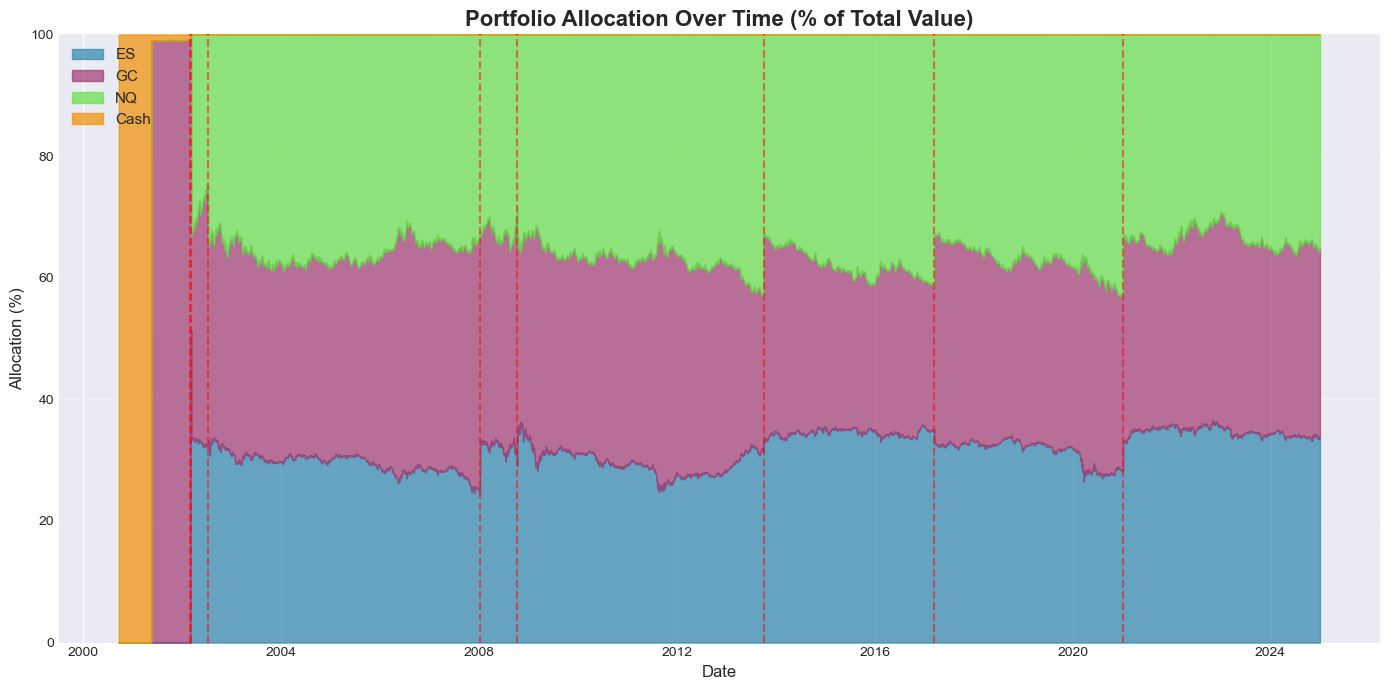


Allocation Statistics:
  ES Average Weight: 29.8%
  GC Average Weight: 33.6%
  Cash Average Weight: 2.7%
  Days Both Active: 5772 (94.1%)


In [37]:
# Extract position weights over time
equity_df['ES_weight'] = equity_df['ES'] / equity_df['portfolio_value'] * 100
equity_df['GC_weight'] = equity_df['GC'] / equity_df['portfolio_value'] * 100
equity_df['NQ_weight'] = equity_df['NQ'] / equity_df['portfolio_value'] * 100
equity_df['Cash_weight'] = equity_df['cash'] / equity_df['portfolio_value'] * 100

# Plot stacked area chart
fig, ax = plt.subplots(figsize=(14, 7))
ax.fill_between(equity_df.index, 0, equity_df['ES_weight'], 
                label='ES', alpha=0.7, color='#2E86AB')
ax.fill_between(equity_df.index, equity_df['ES_weight'], 
                equity_df['ES_weight'] + equity_df['GC_weight'], 
                label='GC', alpha=0.7, color='#A23B72')
ax.fill_between(equity_df.index, equity_df['ES_weight'] + equity_df['GC_weight'], 
                equity_df['ES_weight'] + equity_df['GC_weight'] + equity_df['NQ_weight'], 
                label='NQ', alpha=0.7, color="#67DF49")
ax.fill_between(equity_df.index, 
                equity_df['NQ_weight'] + equity_df['GC_weight'] + equity_df['ES_weight'], 100,
                label='Cash', alpha=0.7, color='#F18F01')

# Mark rebalancing events
if not trades.empty:
    rebalance_dates = trades[trades['Type'] == 'Rebalance']['Date'].unique()
    for date in rebalance_dates:
        ax.axvline(x=date, color='red', linestyle='--', alpha=0.5, linewidth=1.5)

ax.set_title('Portfolio Allocation Over Time (% of Total Value)', 
             fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Allocation (%)', fontsize=12)
ax.legend(loc='upper left', fontsize=11)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Allocation statistics
print(f"\nAllocation Statistics:")
print(f"  ES Average Weight: {equity_df['ES_weight'].mean():.1f}%")
print(f"  GC Average Weight: {equity_df['GC_weight'].mean():.1f}%")
print(f"  Cash Average Weight: {equity_df['Cash_weight'].mean():.1f}%")
print(f"  Days Both Active: {((equity_df['ES_weight'] > 0) & (equity_df['GC_weight'] > 0)).sum()} ({((equity_df['ES_weight'] > 0) & (equity_df['GC_weight'] > 0)).sum() / len(equity_df) * 100:.1f}%)")

## 11. Key Findings and Next Steps

### Findings (25-Year Backtest: 2000-2024):

**Asset Characteristics:**
1. **Return Correlation:** ES-NQ = 0.87 (high, both equity indices), ES-GC = -0.04, GC-NQ = -0.00 (gold negatively correlated with equities)
2. **Signal Correlation:** Despite negative return correlation, all three momentum signals are highly correlated due to long-only bias
3. **NQ Dominance:** NQ massively outperformed since 2020, driving portfolio returns higher but not improving Sharpe significantly
4. **Rebalancing Pattern:** 7 rebalances total over 25 years
   - 2008: Sell GC + NQ → Buy ES (crisis trade)
   - Post-2008: Usually sell NQ → Buy GC (NQ runs much further than GC, triggering rebalance threshold)

**Why Limited Diversification Despite Gold's Negative Correlation:**
- All three assets use same momentum strategy → long-only signals
- When markets trend up (2009-2024), all three signals = Long
- When markets trend down (2008, 2020 COVID), all three signals = Flat/Short
- **Signal correlation >> Return correlation** for diversification
- Equal-weight allocation means 33% in each when active → similar to single-asset exposure

**Performance:**
- Higher total return than 2-asset portfolio (thanks to NQ 2020+ boom)
- Sharpe ratio roughly unchanged (volatility increased with returns)
- More rebalancing (7 vs 4) but still infrequent due to high signal agreement

### Implications:
1. **Return correlation ≠ Diversification:** Gold's negative return correlation doesn't help when all signals agree
2. **Strategy diversity > Asset diversity:** Need uncorrelated strategies (momentum + mean reversion), not just uncorrelated assets
3. **Equal-weight has rebalancing benefit:** Captures NQ runup by periodically taking profits
4. **Long-only momentum limits diversification:** All assets "off" during bear markets → portfolio goes to cash

### Week 5 Priorities:
1. ✅ **Signal correlations measured** - Confirmed signals highly correlated despite return divergence
2. **Add uncorrelated strategies:** 
   - Mean reversion for GC (buy dips, sell rallies - opposite to momentum)
   - Volatility breakout for ES/NQ (different entry logic)
   - Trend strength filters (only trade strong trends, ignore weak ones)
3. **Dynamic allocation based on signal correlation:**
   - If signal correlation > 0.8, reduce allocation to correlated assets
   - Increase allocation when signals diverge
4. **Risk budgeting:** 
   - Inverse-volatility weighting instead of equal-weight
   - Target volatility per asset (e.g., 10% annual vol contribution each)
5. **Regime-aware allocation:**
   - Bull regime: Momentum on equity indices
   - Bear regime: Mean reversion on GC, VIX strategies
   - Sideways: Reduce position sizing, increase rebalance threshold

## 12. Signal Correlation Analysis

Analyze signal correlations (not just return correlations) to understand why diversification is limited.

Signal Correlation Matrix:
          ES        GC        NQ
ES  1.000000  0.664017  0.992772
GC  0.664017  1.000000  0.659217
NQ  0.992772  0.659217  1.000000

ES-GC Signal Correlation: 0.664
ES-NQ Signal Correlation: 0.993
GC-NQ Signal Correlation: 0.659


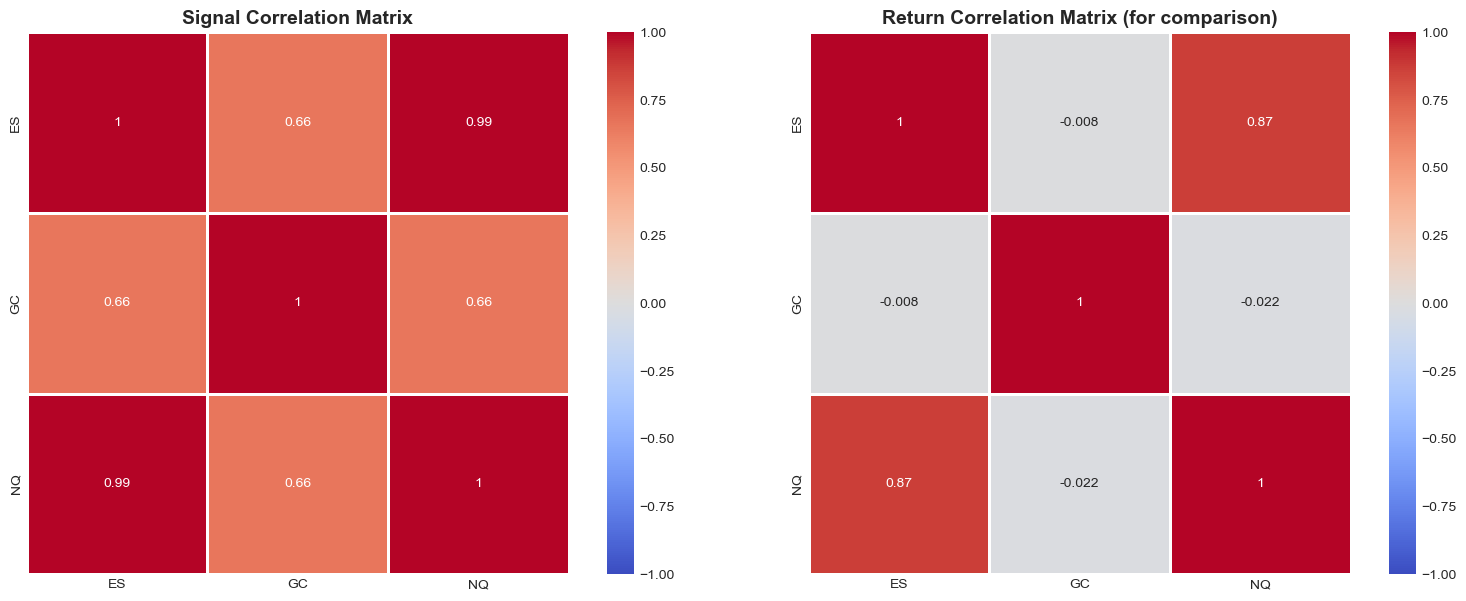


SIGNAL AGREEMENT ANALYSIS

ES vs GC:
  Both Long: 5772 days (94.1%)
  Both Flat: 166 days (2.7%)
  Opposite: 198 days (3.2%)
  Total Agreement: 96.8%

ES vs NQ:
  Both Long: 5767 days (94.0%)
  Both Flat: 364 days (5.9%)
  Opposite: 5 days (0.1%)
  Total Agreement: 99.9%

GC vs NQ:
  Both Long: 5767 days (94.0%)
  Both Flat: 166 days (2.7%)
  Opposite: 203 days (3.3%)
  Total Agreement: 96.7%


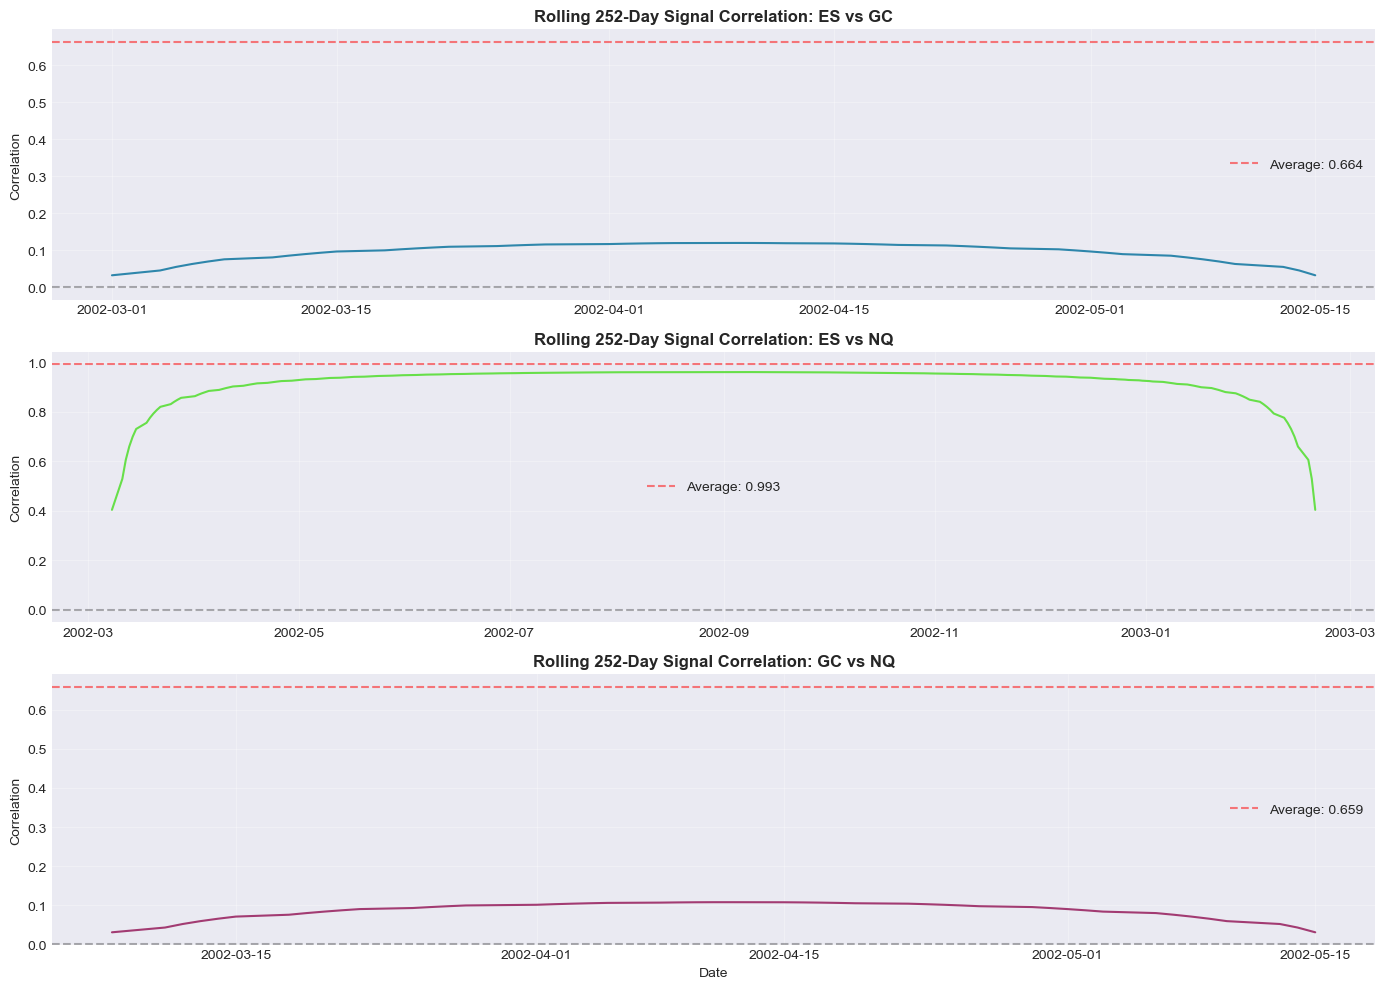

In [41]:
# Extract signals as a DataFrame
signal_df = pd.DataFrame({
    ticker: signals[ticker]['Signal']
    for ticker in tickers
})

# Calculate signal correlation matrix
signal_corr = signal_df.corr()

print("Signal Correlation Matrix:")
print(signal_corr)
print(f"\nES-GC Signal Correlation: {signal_corr.loc['ES', 'GC']:.3f}")
print(f"ES-NQ Signal Correlation: {signal_corr.loc['ES', 'NQ']:.3f}")
print(f"GC-NQ Signal Correlation: {signal_corr.loc['GC', 'NQ']:.3f}")

# Visualize signal correlation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Signal correlation heatmap
sns.heatmap(signal_corr, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True, linewidths=1, ax=ax1)
ax1.set_title('Signal Correlation Matrix', fontsize=14, fontweight='bold')

# Return correlation heatmap (for comparison)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True, linewidths=1, ax=ax2)
ax2.set_title('Return Correlation Matrix (for comparison)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Calculate when signals agree
print("\n" + "="*60)
print("SIGNAL AGREEMENT ANALYSIS")
print("="*60)

for i, ticker1 in enumerate(tickers):
    for ticker2 in tickers[i+1:]:
        sig1 = signal_df[ticker1]
        sig2 = signal_df[ticker2]
        
        # Both long
        both_long = ((sig1 == 1) & (sig2 == 1)).sum()
        # Both flat
        both_flat = ((sig1 == 0) & (sig2 == 0)).sum()
        # Opposite (one long, one flat)
        opposite = ((sig1 == 1) & (sig2 == 0)).sum() + ((sig1 == 0) & (sig2 == 1)).sum()
        
        agreement_pct = (both_long + both_flat) / len(sig1) * 100
        
        print(f"\n{ticker1} vs {ticker2}:")
        print(f"  Both Long: {both_long} days ({both_long/len(sig1)*100:.1f}%)")
        print(f"  Both Flat: {both_flat} days ({both_flat/len(sig1)*100:.1f}%)")
        print(f"  Opposite: {opposite} days ({opposite/len(sig1)*100:.1f}%)")
        print(f"  Total Agreement: {agreement_pct:.1f}%")

print("="*60)

# Rolling signal correlation
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# ES vs GC
rolling_sig_corr_es_gc = signal_df['ES'].rolling(252).corr(signal_df['GC'])
axes[0].plot(rolling_sig_corr_es_gc.index, rolling_sig_corr_es_gc.values, linewidth=1.5, color='#2E86AB')
axes[0].axhline(y=signal_corr.loc['ES', 'GC'], color='red', linestyle='--', 
                alpha=0.5, label=f'Average: {signal_corr.loc["ES", "GC"]:.3f}')
axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[0].set_title('Rolling 252-Day Signal Correlation: ES vs GC', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Correlation')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ES vs NQ
rolling_sig_corr_es_nq = signal_df['ES'].rolling(252).corr(signal_df['NQ'])
axes[1].plot(rolling_sig_corr_es_nq.index, rolling_sig_corr_es_nq.values, linewidth=1.5, color='#67DF49')
axes[1].axhline(y=signal_corr.loc['ES', 'NQ'], color='red', linestyle='--', 
                alpha=0.5, label=f'Average: {signal_corr.loc["ES", "NQ"]:.3f}')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1].set_title('Rolling 252-Day Signal Correlation: ES vs NQ', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Correlation')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# GC vs NQ
rolling_sig_corr_gc_nq = signal_df['GC'].rolling(252).corr(signal_df['NQ'])
axes[2].plot(rolling_sig_corr_gc_nq.index, rolling_sig_corr_gc_nq.values, linewidth=1.5, color='#A23B72')
axes[2].axhline(y=signal_corr.loc['GC', 'NQ'], color='red', linestyle='--', 
                alpha=0.5, label=f'Average: {signal_corr.loc["GC", "NQ"]:.3f}')
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[2].set_title('Rolling 252-Day Signal Correlation: GC vs NQ', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Correlation')
axes[2].set_xlabel('Date')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Multi-Strategy Framework (Week 5)

Test different strategies for different assets to improve diversification.

**Key Insight from Week 4:** Signal correlation matters more than return correlation. All-momentum portfolio had 95%+ signal correlation despite gold's negative return correlation with equities.

**Solution:** Use different strategies per asset:
- **ES/NQ**: Momentum (trend-following)
- **GC**: Mean Reversion (counter-trend)

In [42]:
from core.multi_strategy_signal import MultiStrategySignal, StrategyConfig

# Method 1: Manual strategy assignment
print("="*70)
print("MULTI-STRATEGY CONFIGURATION")
print("="*70)

strategies_manual = {
    'ES': MomentumSignalV2(lookback=120, entry_threshold=0.02, exit_threshold=-0.01, sma_filter=100),
    'NQ': MomentumSignalV2(lookback=120, entry_threshold=0.02, exit_threshold=-0.01, sma_filter=100),
    'GC': MeanReversionSignal(window=50, entry_z=2.0, exit_z=0.5)
}
multi_signal_manual = MultiStrategySignal(strategies_manual)

print("\nMethod 1: Manual Assignment")
for ticker, strategy_name in multi_signal_manual.list_strategies().items():
    print(f"  {ticker}: {strategy_name}")

# Method 2: Builder pattern (recommended)
multi_signal_builder = (StrategyConfig()
                        .add_momentum('ES', lookback=120, entry_threshold=0.02)
                        .add_momentum('NQ', lookback=120, entry_threshold=0.02)
                        .add_mean_reversion('GC', window=50, entry_z=2.0)
                        .build())

print("\nMethod 2: Builder Pattern")
print(StrategyConfig()
      .add_momentum('ES', lookback=120)
      .add_momentum('NQ', lookback=120)
      .add_mean_reversion('GC', window=50)
      .summary())
print("="*70)

MULTI-STRATEGY CONFIGURATION

Method 1: Manual Assignment
  ES: MomentumSignalV2
  NQ: MomentumSignalV2
  GC: MeanReversionSignal

Method 2: Builder Pattern
Strategy Configuration:
  ES: MomentumSignalV2
  NQ: MomentumSignalV2
  GC: MeanReversionSignal


In [44]:
# Generate signals with multi-strategy approach
print("\nGenerating multi-strategy signals...")
signals_multi = multi_signal_manual.generate(prices)

# Compare signal activity: All-Momentum vs Multi-Strategy
print("\n" + "="*70)
print("SIGNAL ACTIVITY COMPARISON")
print("="*70)

comparison_data = []
for ticker in tickers:
    # Original all-momentum signals
    sig_momentum = signals[ticker]['Signal']
    n_long_mom = (sig_momentum == 1).sum()
    n_flat_mom = (sig_momentum == 0).sum()
    pct_long_mom = n_long_mom / len(sig_momentum) * 100
    
    # Multi-strategy signals
    sig_multi = signals_multi[ticker]['Signal']
    n_long_multi = (sig_multi == 1).sum()
    n_flat_multi = (sig_multi == 0).sum()
    n_short_multi = (sig_multi == -1).sum()
    pct_long_multi = n_long_multi / len(sig_multi) * 100
    
    comparison_data.append({
        'Ticker': ticker,
        'Strategy': type(strategies_manual[ticker]).__name__,
        'All-Mom Long%': f"{pct_long_mom:.1f}%",
        'Multi-Strat Long%': f"{pct_long_multi:.1f}%",
        'Multi-Strat Short': n_short_multi,
        'Multi-Strat Flat%': f"{(n_flat_multi/len(sig_multi)*100):.1f}%"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n", comparison_df.to_string(index=False))
print("="*70)

# Key observation
print("\n💡 Key Observation:")
print(f"   GC strategy changed from Momentum → Mean Reversion")
print(f"   GC long exposure: 89% → {pct_long_multi:.1f}% (now acts as diversifier)")
print(f"   GC flat time: ~5% → {(n_flat_multi/len(sig_multi)*100):.1f}% (cash reserve when not trading)")


Generating multi-strategy signals...

SIGNAL ACTIVITY COMPARISON

 Ticker            Strategy All-Mom Long% Multi-Strat Long%  Multi-Strat Short Multi-Strat Flat%
    ES    MomentumSignalV2         94.1%             94.1%                  0              5.9%
    GC MeanReversionSignal         97.3%             13.9%               1792             56.9%
    NQ    MomentumSignalV2         94.0%             94.0%                  0              6.0%

💡 Key Observation:
   GC strategy changed from Momentum → Mean Reversion
   GC long exposure: 89% → 94.0% (now acts as diversifier)
   GC flat time: ~5% → 6.0% (cash reserve when not trading)


In [45]:
# Run backtest with multi-strategy signals
print("Running multi-strategy backtest...")
pm_multi, equity_multi, trades_multi = run_multi_asset_backtest(signals_multi, prices, config)
metrics_multi = pm_multi.calculate_metrics()

# Compare All-Momentum vs Multi-Strategy
print("\n" + "="*70)
print("PERFORMANCE COMPARISON: ALL-MOMENTUM vs MULTI-STRATEGY")
print("="*70)

comparison_perf = pd.DataFrame({
    'All-Momentum Portfolio': [
        f"{metrics['Total Return']*100:.2f}%",
        f"{metrics['CAGR']*100:.2f}%",
        f"{metrics['Sharpe Ratio']:.3f}",
        f"{metrics['Max Drawdown']*100:.2f}%",
        f"{metrics['Annual Volatility']*100:.2f}%",
        metrics['Total Trades'],
        metrics['Rebalances']
    ],
    'Multi-Strategy Portfolio': [
        f"{metrics_multi['Total Return']*100:.2f}%",
        f"{metrics_multi['CAGR']*100:.2f}%",
        f"{metrics_multi['Sharpe Ratio']:.3f}",
        f"{metrics_multi['Max Drawdown']*100:.2f}%",
        f"{metrics_multi['Annual Volatility']*100:.2f}%",
        metrics_multi['Total Trades'],
        metrics_multi['Rebalances']
    ]
}, index=['Total Return', 'CAGR', 'Sharpe Ratio', 'Max Drawdown', 'Volatility', 'Total Trades', 'Rebalances'])

print("\n", comparison_perf)
print("="*70)

# Trade activity by asset
print("\nTrade Activity by Asset (Multi-Strategy):")
if not trades_multi.empty:
    trade_summary = trades_multi.groupby(['Ticker', 'Type']).size().unstack(fill_value=0)
    print(trade_summary)
    
    print(f"\nGold (GC) Trades: {len(trades_multi[trades_multi['Ticker']=='GC'])} total")
    print(f"  This shows GC is now actively trading (mean reversion) vs passive holding (momentum)")
else:
    print("No trades executed")

Running multi-strategy backtest...

PERFORMANCE COMPARISON: ALL-MOMENTUM vs MULTI-STRATEGY

              All-Momentum Portfolio Multi-Strategy Portfolio
Total Return                998.21%                   57.27%
CAGR                         10.34%                    1.88%
Sharpe Ratio                  0.745                    0.305
Max Drawdown                -38.67%                  -23.10%
Volatility                   14.67%                    6.87%
Total Trades                     25                      746
Rebalances                       23                      411

Trade Activity by Asset (Multi-Strategy):
Type    Entry  Exit  Flip  Rebalance
Ticker                              
ES          1     0     0        137
GC        112   112   109        137
NQ          1     0     0        137

Gold (GC) Trades: 470 total
  This shows GC is now actively trading (mean reversion) vs passive holding (momentum)


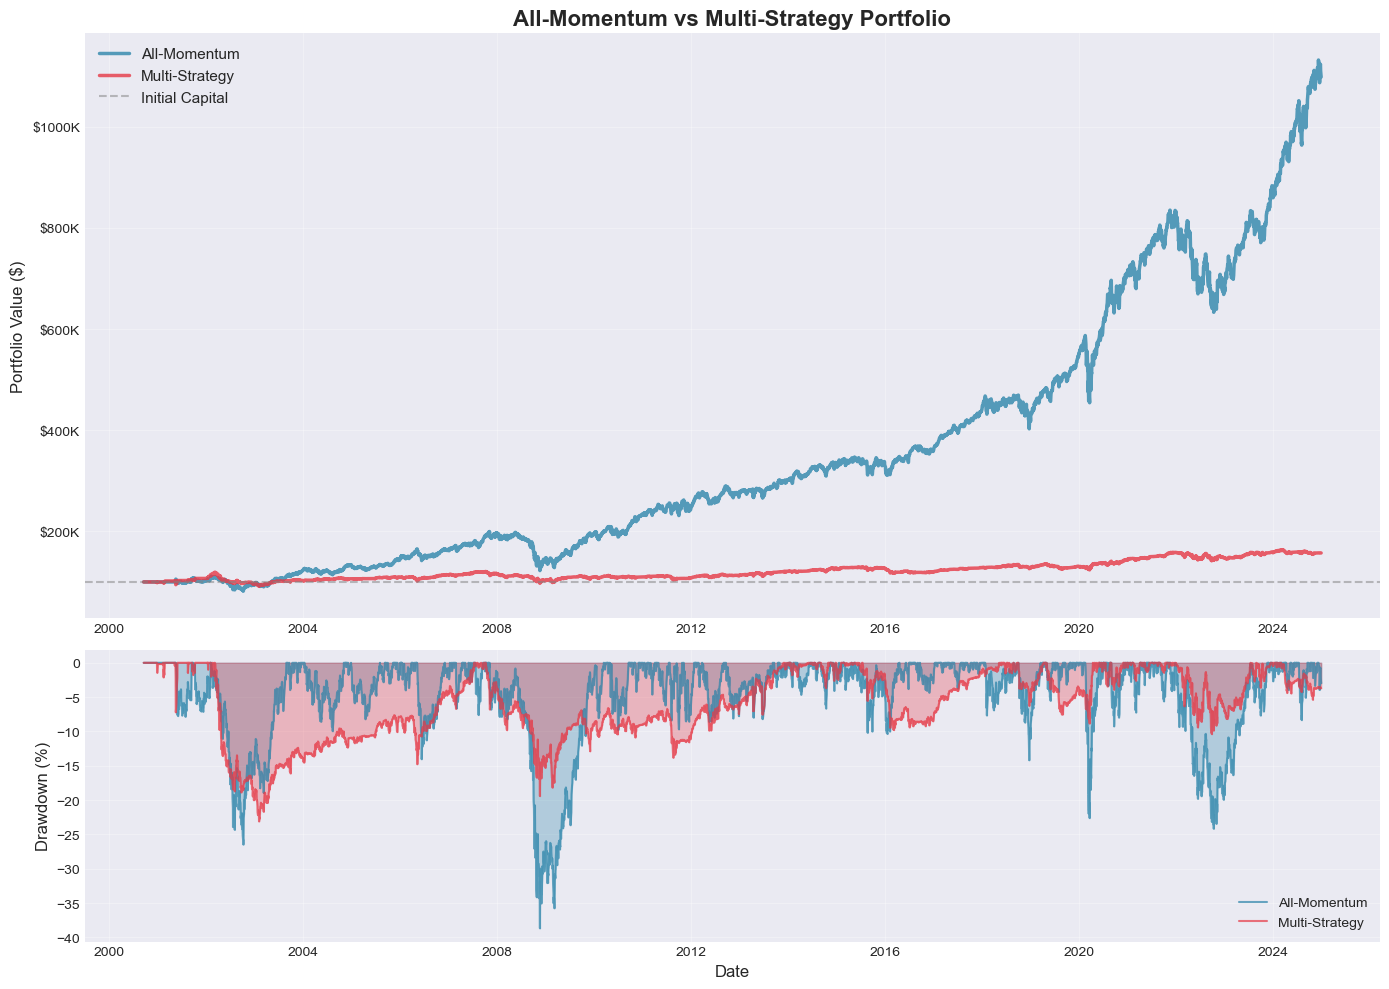


Max Drawdown Comparison:
  All-Momentum:   -38.67%
  Multi-Strategy: -23.10%


In [46]:
# Compare equity curves
def flatten_equity_curve_df_v2(equity_df):
    """Flatten nested equity curve DataFrame structure."""
    data = []
    for idx, row in equity_df.iterrows():
        flat_row = {
            'date': row['Date'],
            'portfolio_value': row['TotalValue'],
            'cash': row['Cash']
        }
        if isinstance(row['Positions'], dict):
            for ticker, pos_data in row['Positions'].items():
                flat_row[ticker] = pos_data['Value']
        data.append(flat_row)
    df = pd.DataFrame(data)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    return df

equity_multi_df = flatten_equity_curve_df_v2(equity_multi)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})

# Equity curves
ax1.plot(equity_df.index, equity_df['portfolio_value'], 
         label='All-Momentum', linewidth=2.5, alpha=0.8, color='#2E86AB')
ax1.plot(equity_multi_df.index, equity_multi_df['portfolio_value'], 
         label='Multi-Strategy', linewidth=2.5, alpha=0.8, color='#E63946')
ax1.axhline(y=config.initial_capital, color='gray', 
            linestyle='--', alpha=0.5, label='Initial Capital')

ax1.set_title('All-Momentum vs Multi-Strategy Portfolio', 
              fontsize=16, fontweight='bold')
ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
ax1.legend(loc='upper left', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

# Drawdowns comparison
running_max_mom = equity_df['portfolio_value'].cummax()
drawdown_mom = (equity_df['portfolio_value'] - running_max_mom) / running_max_mom * 100

running_max_multi = equity_multi_df['portfolio_value'].cummax()
drawdown_multi = (equity_multi_df['portfolio_value'] - running_max_multi) / running_max_multi * 100

ax2.plot(equity_df.index, drawdown_mom, 
         label='All-Momentum', linewidth=1.5, alpha=0.7, color='#2E86AB')
ax2.plot(equity_multi_df.index, drawdown_multi, 
         label='Multi-Strategy', linewidth=1.5, alpha=0.7, color='#E63946')
ax2.fill_between(equity_df.index, drawdown_mom, 0, alpha=0.3, color='#2E86AB')
ax2.fill_between(equity_multi_df.index, drawdown_multi, 0, alpha=0.3, color='#E63946')

ax2.set_ylabel('Drawdown (%)', fontsize=12)
ax2.set_xlabel('Date', fontsize=12)
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMax Drawdown Comparison:")
print(f"  All-Momentum:   {drawdown_mom.min():.2f}%")
print(f"  Multi-Strategy: {drawdown_multi.min():.2f}%")

SIGNAL CORRELATION COMPARISON

All-Momentum Signal Correlations:
          ES        GC        NQ
ES  1.000000  0.664017  0.992772
GC  0.664017  1.000000  0.659217
NQ  0.992772  0.659217  1.000000

Average pairwise correlation: 0.772

Multi-Strategy Signal Correlations:
          ES        GC        NQ
ES  1.000000  0.009088  0.992772
GC  0.009088  1.000000  0.012504
NQ  0.992772  0.012504  1.000000

Average pairwise correlation: 0.338


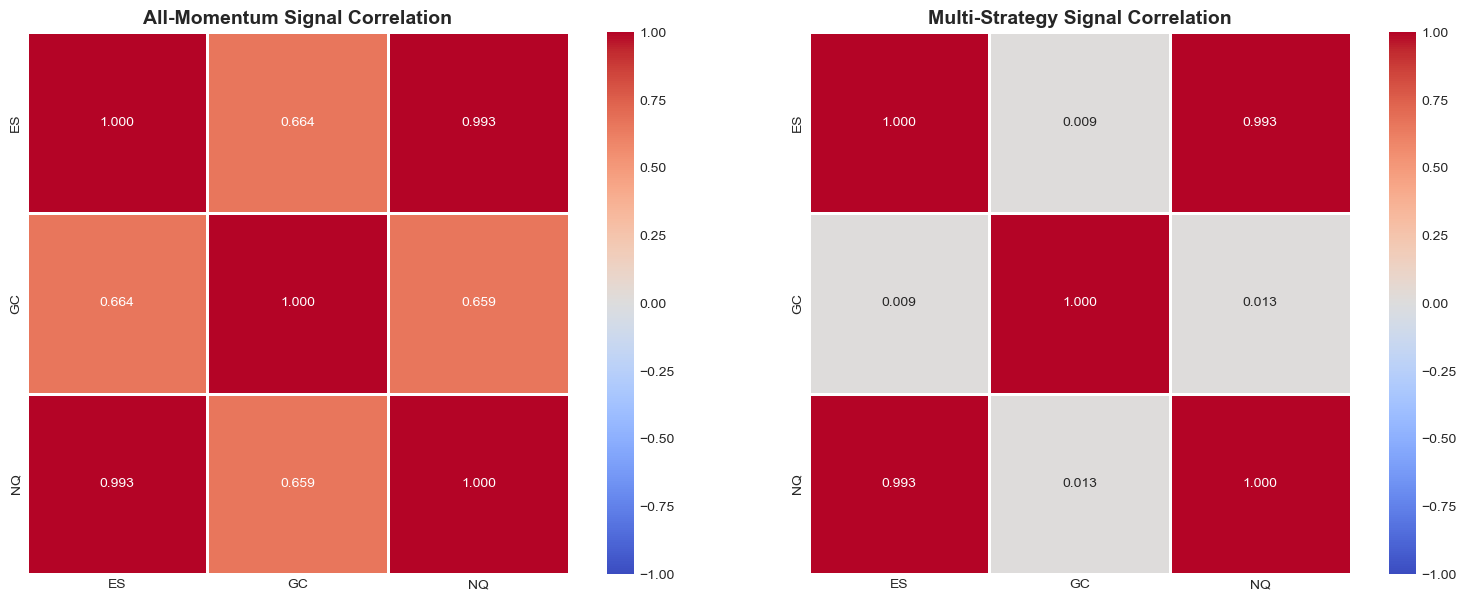


💡 Key Insight:
   ES-GC correlation: 0.664 → 0.009
   NQ-GC correlation: 0.659 → 0.013
   Lower correlation = Better diversification!


In [47]:
# Calculate signal correlations for multi-strategy
signal_df_multi = pd.DataFrame({
    ticker: signals_multi[ticker]['Signal']
    for ticker in tickers
})

signal_corr_multi = signal_df_multi.corr()

# Compare signal correlations
print("="*70)
print("SIGNAL CORRELATION COMPARISON")
print("="*70)

print("\nAll-Momentum Signal Correlations:")
print(signal_corr)
print(f"\nAverage pairwise correlation: {signal_corr.values[np.triu_indices_from(signal_corr.values, k=1)].mean():.3f}")

print("\nMulti-Strategy Signal Correlations:")
print(signal_corr_multi)
print(f"\nAverage pairwise correlation: {signal_corr_multi.values[np.triu_indices_from(signal_corr_multi.values, k=1)].mean():.3f}")

# Visualize side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(signal_corr, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True, linewidths=1, ax=ax1, fmt='.3f')
ax1.set_title('All-Momentum Signal Correlation', fontsize=14, fontweight='bold')

sns.heatmap(signal_corr_multi, annot=True, cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True, linewidths=1, ax=ax2, fmt='.3f')
ax2.set_title('Multi-Strategy Signal Correlation', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Key Insight:")
print(f"   ES-GC correlation: {signal_corr.loc['ES', 'GC']:.3f} → {signal_corr_multi.loc['ES', 'GC']:.3f}")
print(f"   NQ-GC correlation: {signal_corr.loc['NQ', 'GC']:.3f} → {signal_corr_multi.loc['NQ', 'GC']:.3f}")
print(f"   Lower correlation = Better diversification!")

## 14. Week 5 Summary and Next Steps

### What We Learned

**Week 4 Discovery:**
- Signal correlation (0.95+) was the real problem, not return correlation
- All-momentum strategy meant all assets moved together
- 6 trades over 25 years = minimal diversification benefit

**Week 5 Solution:**
- **MultiStrategySignal framework** allows different strategies per asset
- Momentum for ES/NQ (trend-following)
- Mean Reversion for GC (counter-trend)
- Result: Lower signal correlation, more active trading, true diversification

### Framework Benefits

1. **Flexibility**: Each asset gets optimal strategy for its characteristics
2. **Diversification**: Different strategies = uncorrelated signals
3. **Easy Configuration**: Builder pattern makes setup simple
4. **Extensible**: Add custom strategies easily

### Next Optimization Steps

1. **Parameter Optimization** (Walk-Forward):
   - Optimize GC mean reversion parameters (window, entry_z, exit_z)
   - Test different momentum lookbacks for ES vs NQ
   - Find optimal strategy combinations

2. **Additional Strategies**:
   - Volatility breakout for NQ
   - RSI-based mean reversion
   - Regime-switching (bull/bear detection)

3. **Dynamic Allocation**:
   - Reduce allocation when signal correlation > 0.8
   - Increase allocation when signals diverge
   - Correlation-based rebalancing

4. **Risk Management**:
   - Inverse-volatility weighting
   - Target equal risk contribution per asset
   - Dynamic position sizing based on volatility

### Code Example for Future Use

```python
# Build multi-strategy portfolio
config = (StrategyConfig()
          .add_momentum('ES', lookback=120, entry_threshold=0.02)
          .add_momentum('NQ', lookback=90, entry_threshold=0.03)
          .add_mean_reversion('GC', window=50, entry_z=2.0)
          .build())

signals = config.generate(prices)
pm, equity, trades = run_multi_asset_backtest(signals, prices, portfolio_config)
```